In [70]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

# import scienceplots
import seaborn as sns
from darts import TimeSeries
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from tqdm.auto import tqdm

In [71]:
warnings.filterwarnings("ignore")

In [72]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_theme()
# plt.style.use(['ieee','no-latex'])


rcParams['figure.figsize'] = 16, 10
# tqdm.pandas()

In [73]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))

In [74]:
static_uids = sorted(df_static.Uid.unique().tolist())
display(static_uids)

['45tHAXkk',
 '4u4uNEHg',
 'AMcyZBRZ',
 'CSyiTD67',
 'FWgQihFY',
 'GkLNvAxk',
 'JX5ctgXk',
 'Jg5gZWT9',
 'JuJhmMUS',
 'KWkqdhLs',
 'L2Gc6KFE',
 'NNM8S6cc',
 'ThHnpx5h',
 'VVtpjXhe',
 'X5rS2fPs',
 'Zk7wQePj',
 'aTx448ZX',
 'eoHUrkbG',
 'in2JGSH5',
 'j9aQcpma',
 'm3xmyiFu',
 'mDVN6DYG',
 'nQK8dP5x']

In [86]:
test_df = (
    df_static[df_static.Uid == static_uids[0]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

In [87]:
test_df

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 13:40:04,-103.0,-15.0,1.0,15.0,-90.0
2019-12-16 13:40:05,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:06,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:07,-104.0,-14.0,-7.0,11.0,-88.0
2019-12-16 13:40:08,-104.0,-14.0,-7.0,11.0,-88.0
...,...,...,...,...,...
2019-12-16 14:18:01,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:02,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:03,-100.0,-14.0,0.0,9.0,-87.0


<Axes: xlabel='Timestamp'>

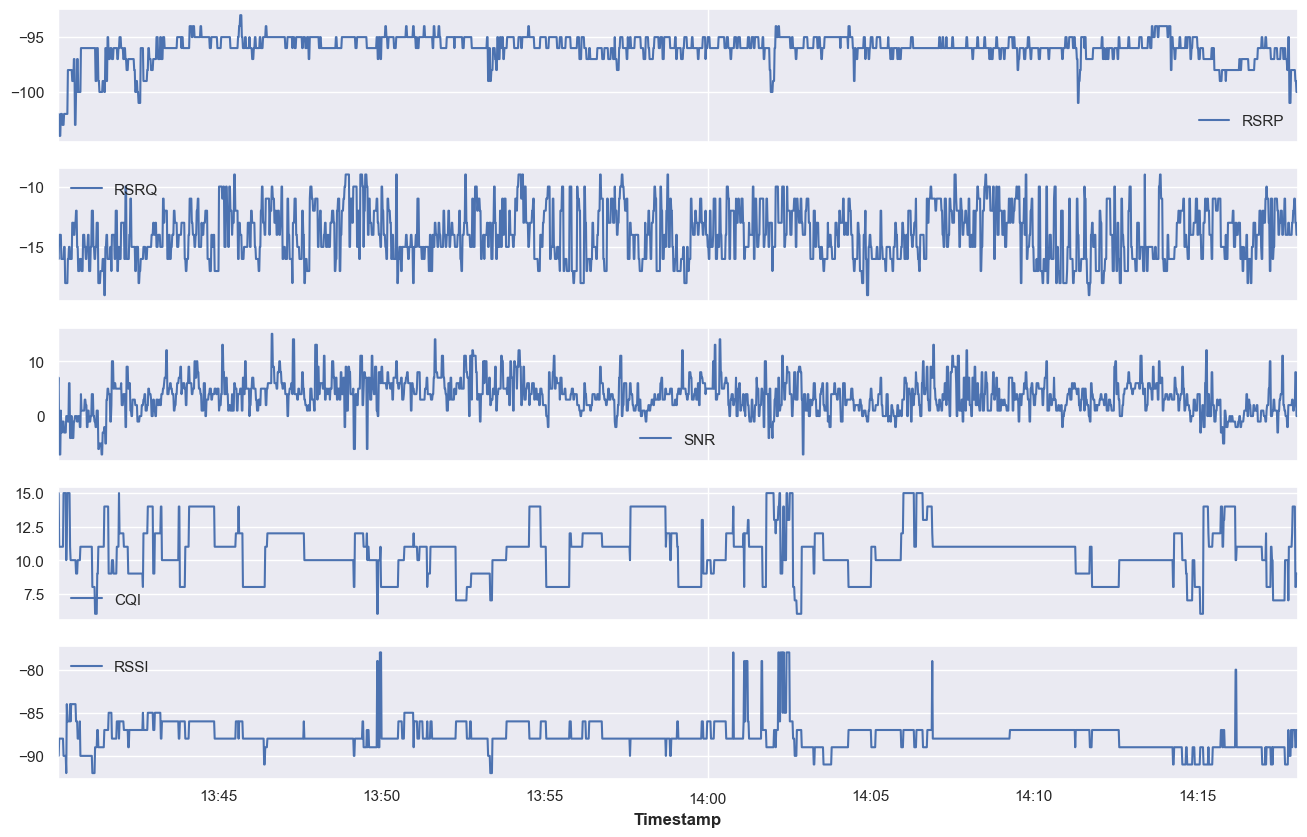

In [88]:
fig, ax = plt.subplots(5, 1)
test_df.plot(kind="line", sharex=True, y="RSRP", color="b", ax=ax[0])
test_df.plot(kind="line", sharex=True, y="RSRQ", color="b", ax=ax[1])
test_df.plot(kind="line", sharex=True, y="SNR", color="b", ax=ax[2])
test_df.plot(kind="line", sharex=True, y="CQI", color="b", ax=ax[3])
test_df.plot(kind="line", sharex=True, y="RSSI", color="b", ax=ax[4])

In [78]:
ts_static = TimeSeries.from_dataframe(
    test_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    # fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    # freq="s",
)

In [79]:
ts_static.pd_dataframe()

component,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 13:40:04,-103.0,-15.0,1.0,15.0,-90.0
2019-12-16 13:40:05,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:06,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:07,-104.0,-14.0,-7.0,11.0,-88.0
2019-12-16 13:40:08,-104.0,-14.0,-7.0,11.0,-88.0
...,...,...,...,...,...
2019-12-16 14:18:01,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:02,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:03,NaN,NaN,NaN,NaN,NaN


## The Hodrick-Prescott Filter:

Separetes a time-series $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$.

$$ y_t = \tau_t + c_t $$

In [80]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [81]:
RSRP_cycle, RSRP_trend = hpfilter(test_df["RSRP"], lamb=1600)

<Axes: xlabel='Timestamp'>

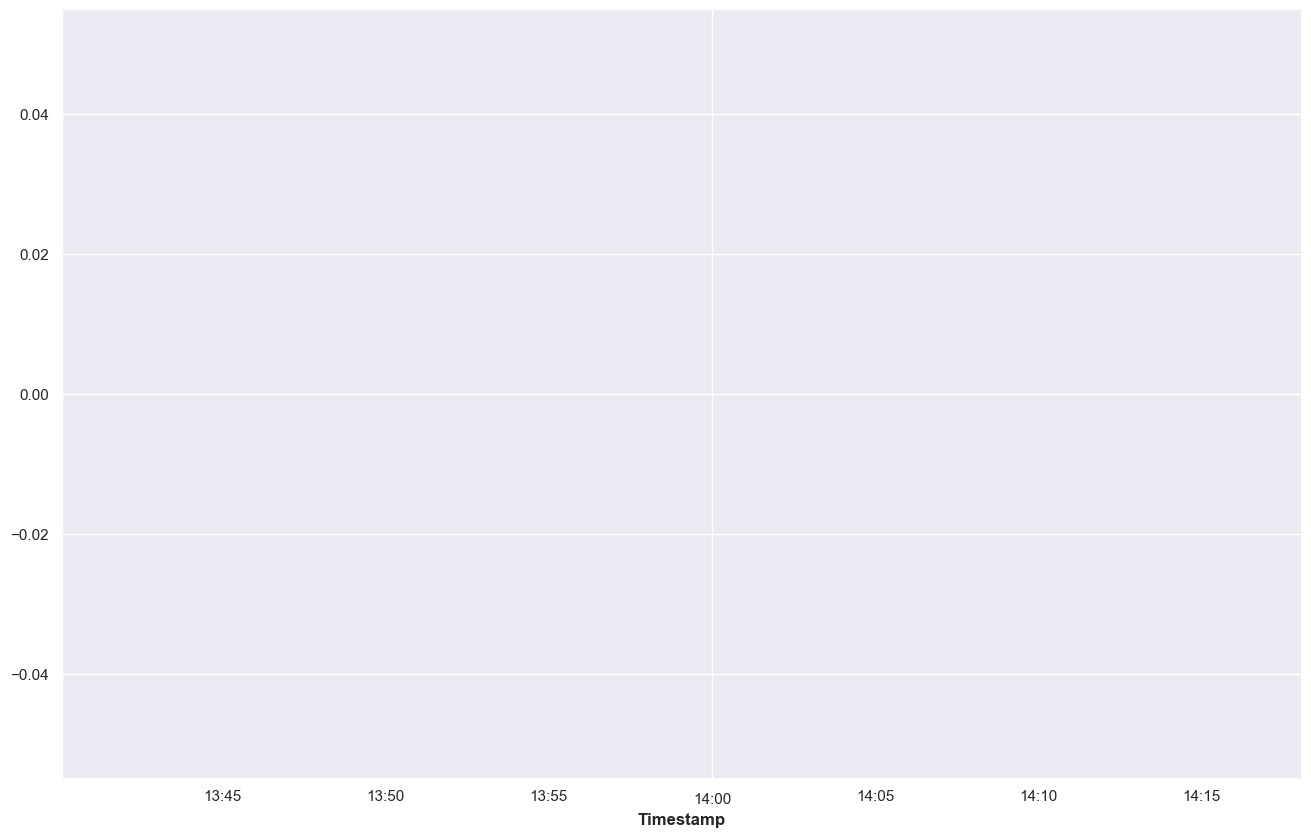

In [82]:
RSRP_cycle.plot()

<Axes: xlabel='Timestamp'>

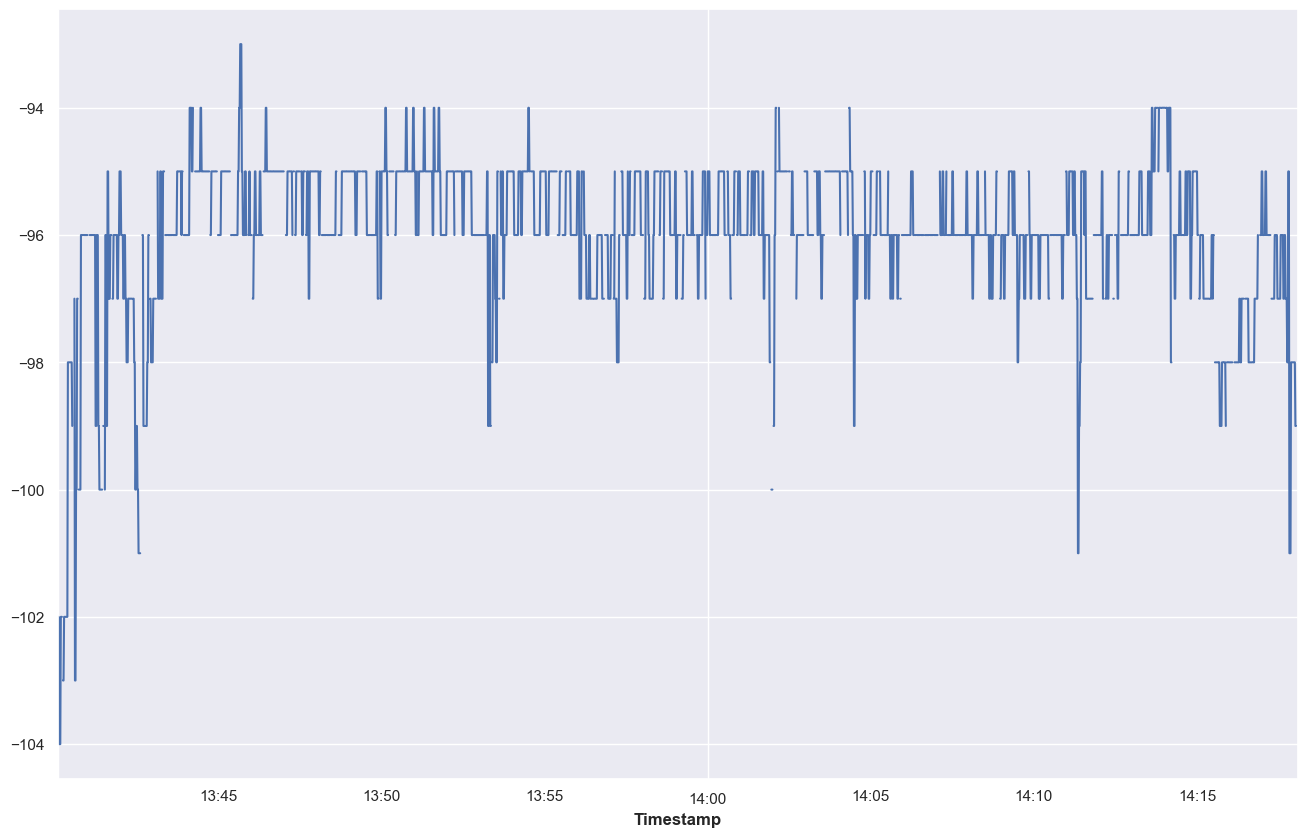

In [83]:
test_df["RSRP"].plot()
RSRP_trend.plot()

## The ETS (Error-Trend-Seasonality) Models:

ETS (Exponential Smoothing) is a time series forecasting technique that combines three main components: error (E), trend (T), and seasonality (S). It smooths past data to predict future values by applying exponentially decreasing weights over time. There are various types of ETS models, including additive and multiplicative models, depending on how trend and seasonality interact with the time series data. ETS is particularly useful for data exhibiting seasonal patterns and trends, enabling accurate forecasts in scenarios where these components are significant.

- An additive model is applied when the trend appears linear and both the seasonality and trend components seem constant over time.
- A multiplicative model is more appropriate when the trend is increasing (or decreasing) at a non-linear rate.

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [85]:
seasonal_decompose(test_df["RSRP"], model="add", period=60).plot()

ValueError: This function does not handle missing values

## Rolling Moving Average

<Axes: xlabel='Timestamp'>

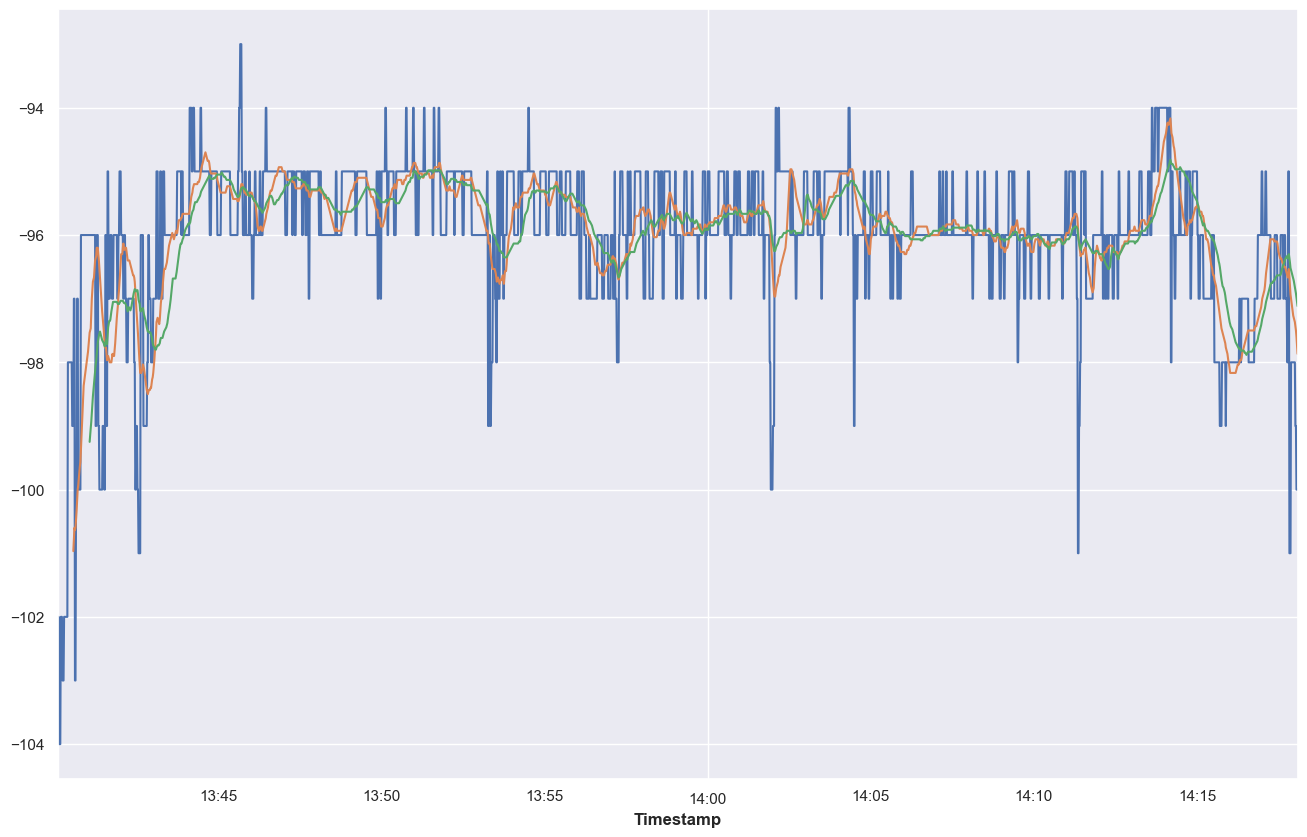

In [ ]:
test_df["RSRP"].plot()
test_df["RSRP"].rolling(window=30).mean().plot()
test_df["RSRP"].rolling(window=60).mean().plot()

## EWMA (Exponentially weighted moving average)

<Axes: xlabel='Timestamp'>

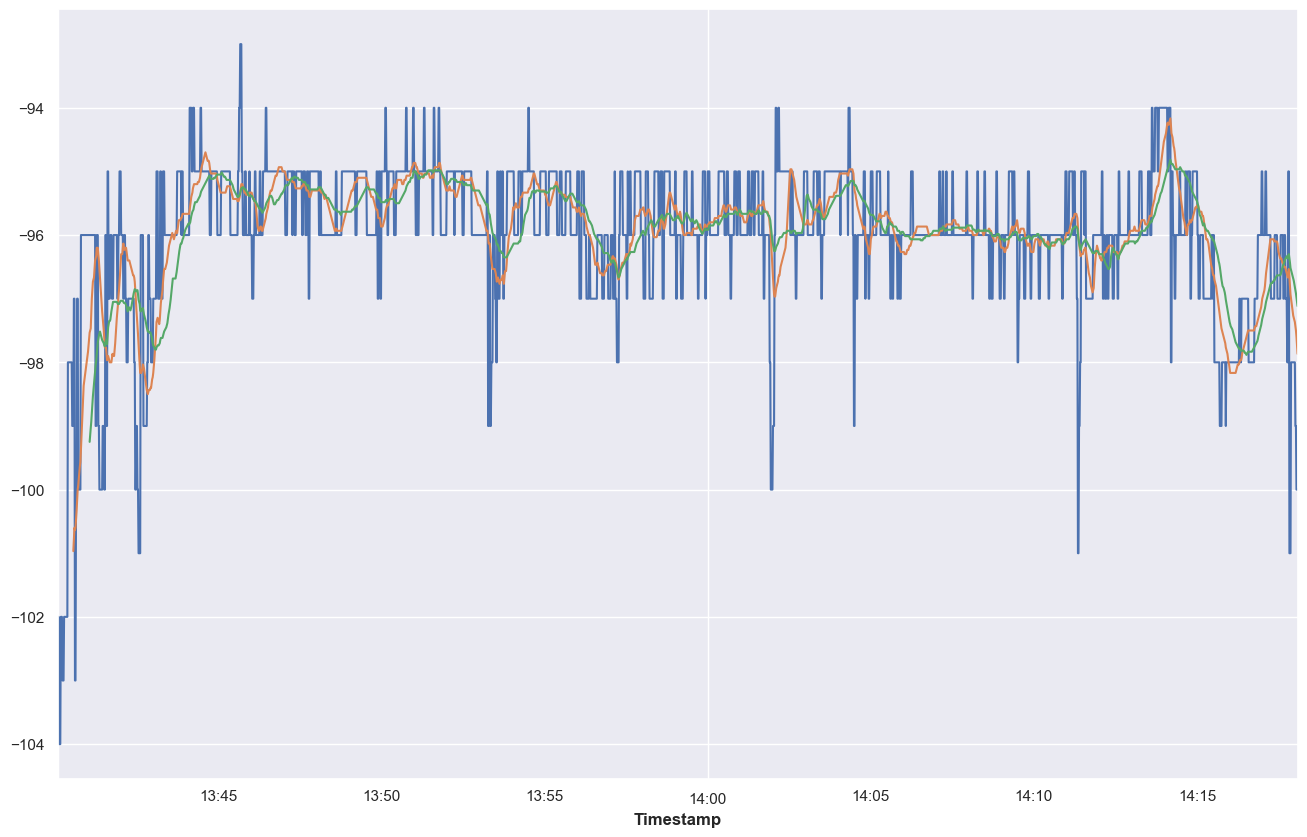

In [ ]:
test_df["RSRP"].plot()
test_df["RSRP"].rolling(window=30).mean().plot()
test_df["RSRP"].rolling(window=60).mean().plot()

<Axes: xlabel='Timestamp'>

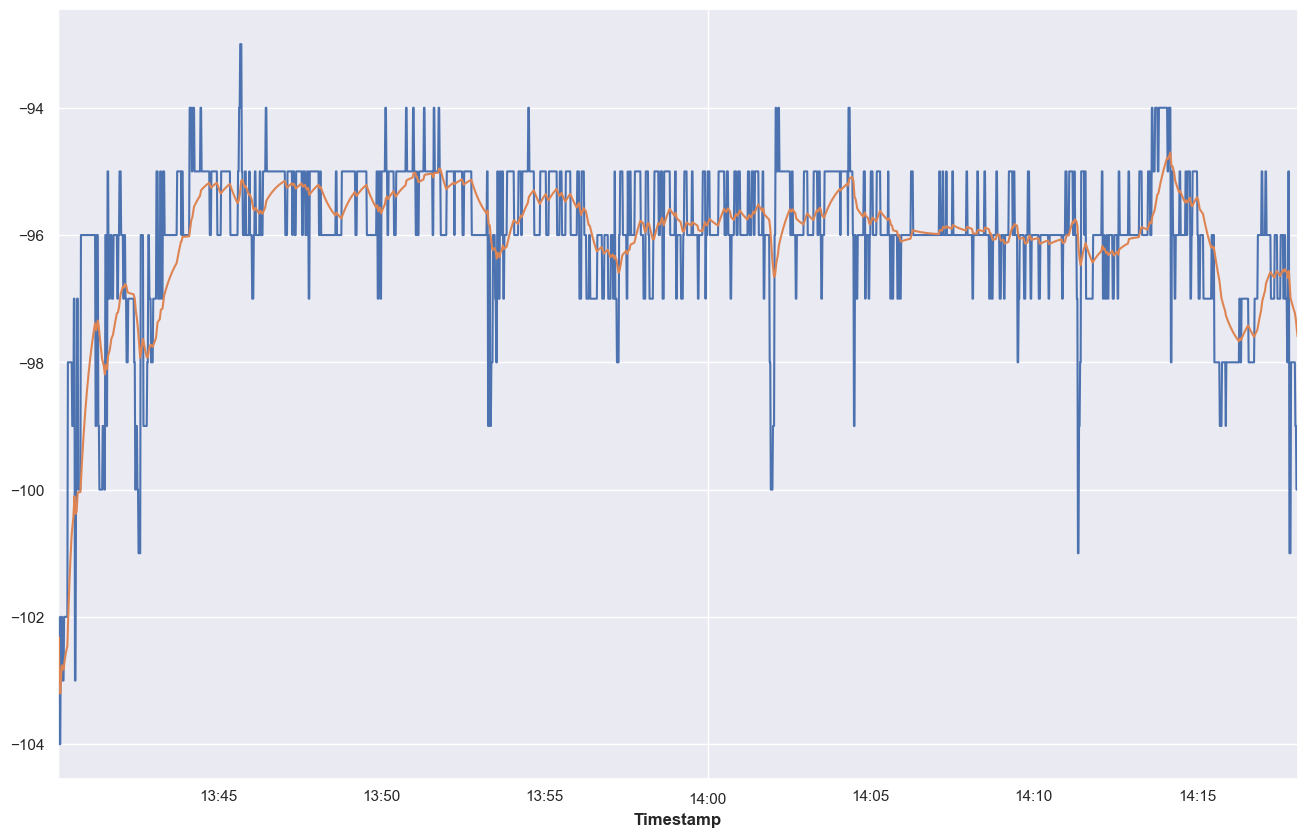

In [ ]:
test_df["RSRP"].plot()
test_df["RSRP"].ewm(span=60).mean().plot()

Estudar:

  - https://www.youtube.com/watch?v=CAT0Y66nPhs
  - https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

Código para referência:

- https://github.com/KareemElozeiri/CQI-Timeseries-Forecasting/blob/main/notebooks/CQI_Time_Series_Forecasting.ipynb